In [348]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis import *
from getters import * 
from plotters import * 

views=[0]
models=["gcn_student_ensamble_3"]
CV=["3Fold", "5Fold", "10Fold"]
run=0
dataset = "gender_data"
gcn_student_ensamble_args = {
    "num_epochs":50, 
    "lr": 0.0001, # 0.0001 when training without teacher
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student_ensamble_3",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha": 1, # ensamble ce loss
    "beta": 2,  # ensamble kd loss
    "gamma": 2, # sum of student ce loss
    "lambda":1, # disentanglement loss
    "T": 3, #Temperature parameter for soft logit target 
    "n_students":3 # TOTAL number of students in ensamble 
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
view_data_mean_1, _ = view_reproducibility_analysis(dataset, models, CV, views, run, student=0, model_args=[gcn_student_ensamble_args])
view_data_mean_2, _ = view_reproducibility_analysis(dataset, models, CV, views, run, student=1, model_args=[gcn_student_ensamble_args])
view_data_mean_3, _ = view_reproducibility_analysis(dataset, models, CV, views, run, student=2, model_args=[gcn_student_ensamble_args])

In [41]:
view_data_mean_1, view_data_mean_2, view_data_mean_3

(array([[0.87777778, 0.87777778]]),
 array([[1., 1.]]),
 array([[0.96666667, 0.96666667]]))

In [349]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [187]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=gcn_student_ensamble_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [178]:
def get_best_student_ensamble(model, view, CV, runs, dataset_split, analysis_type, model_args):
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    print(all_student_metrics_mean)

    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

In [212]:
runs = [i for i in range(10)]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_3"
analysis_type="model_assessment"
model_args= gcn_student_ensamble_args
dataset_split="val"
view=2

get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)

([array([0.60474145, 0.45836475, 0.38742723, 0.57715741]),
  array([0.62753818, 0.56597294, 0.55822156, 0.5805655 ]),
  array([0.60452934, 0.42695278, 0.34464217, 0.59591662])],
 [array([1.13464091e-05, 5.39445352e-04, 1.20166870e-03, 4.37011047e-05]),
  array([1.25701121e-05, 4.20667370e-05, 2.88010931e-04, 3.56183255e-05]),
  array([5.61213317e-05, 4.51789734e-04, 1.13234225e-03, 5.51090741e-04])])

In [215]:
get_best_student_ensamble(
    model="gcn_student_ensamble_3", 
    view=5, 
    CV=CV,
    runs=[i for i in range(10)], 
    analysis_type=analysis_type,
    dataset_split=dataset_split,
    model_args=gcn_student_ensamble_args
)

/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

[array([0.58988822, 0.29641227, 0.21015161, 0.6259179 ]), array([0.63574188, 0.59240074, 0.60697492, 0.58418499]), array([0.56780347, 0.15380117, 0.10136436, 0.51674426])]


/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([0.9486111111111111, 0.0003387345679012343, 0],
 [0.9126388888888888, 0.0003250192901234564, 1],
 [0.9126388888888888, 0.0003250192901234564, 1])

## Overview of the models and ensamble 

In [396]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:
                
                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=gcn_student_ensamble_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [ ]:
def get_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average metrics across all runs and all cv for all models in ensemble 

    data_mean = [] 
    data_var = [] 

    run_data = []   

    for run in runs:

        model_metrics = []
        
        for training_type in CV:
            
            model_cv_metrics = get_mean_CV_metric_student_model(
                dataset=dataset, 
                model=model, 
                analysis_type=analysis_type, 
                training_type=training_type, 
                view=view, 
                run=run, 
                student=student, 
                dataset_split=dataset_split,
                model_args=gcn_student_ensamble_args
                )
            model_metrics.append(model_cv_metrics)
        
        run_data.append(model_metrics)
        
    data_mean.append(np.mean(run_data, axis=0))   
    data_var.append(np.std(run_data, axis=0))        

    return data_mean, data_var

In [436]:
views=[0, 2, 4, 5]

gcn_args = {
    "num_epochs":50, 
    "lr": 0.0001,
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn",
    "layers":2,
    "evaluation_method": "model_assessment" # model selection or model assessment
}

gcn_student_args = {
    "num_epochs":50, 
    "lr": 0.0001, 
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 3, 
    "alpha_soft_ce": 2,
    "alpha_weight": 0
}
#models=["gcn", "gcn_student", "gcn_student_teacher"]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_3"
runs = [i for i in range(9)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc", "f1", "recall", "precision"]
model_args= gcn_student_ensamble_args

for view in views:

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args) 
    mean_gcn, std_gcn = get_model_metric(dataset=dataset, model="gcn", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_args)
    mean_gcn_student, std_gcn_student = get_model_metric(dataset=dataset, model="gcn_student", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_student_args)
    mean_gcn_ts, std_gcn_ts = get_model_metric(dataset=dataset, model="gcn_student_teacher", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_student_args)
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = pd.DataFrame(np.array(mean)[:,:,i], columns=CV, index=["Student 1", "Student 2", "Student 3"]).round(3)
        std_df = pd.DataFrame(np.array(std)[:,:,i], columns=CV, index=["Student 1", "Student 2", "Student 3"]).round(3)
        
        mean_gcn_df = pd.DataFrame(np.array(mean_gcn)[:,:,i], columns=CV, index=["GCN"]).round(3)
        std_gcn_df = pd.DataFrame(np.array(std_gcn)[:,:,i], columns=CV, index=["GCN"]).round(3)

        mean_gcn_student_df = pd.DataFrame(np.array(mean_gcn_student)[:,:,i], columns=CV, index=["GCN Student"]).round(3)
        std_gcn_student_df = pd.DataFrame(np.array(std_gcn_student)[:,:,i], columns=CV, index=["GCN Student"]).round(3)

        mean_gcn_ts_df = pd.DataFrame(np.array(mean_gcn_ts)[:,:,i], columns=CV, index=["Vanilla KD"]).round(3)
        std_gcn_ts_df = pd.DataFrame(np.array(std_gcn_ts)[:,:,i], columns=CV, index=["Vanilla KD"]).round(3)
        
        final_mean_df = pd.concat([mean_gcn_df, mean_gcn_student_df, mean_gcn_ts_df, mean_df])
        final_var_df = pd.concat([std_gcn_df, std_gcn_student_df, std_gcn_ts_df, std_df])

        print(final_mean_df.astype(str) + u"\u00B1" + final_var_df.astype(str))

/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


____________________________________________________
View: 0 Metric: acc
                   3Fold        5Fold       10Fold
GCN           0.61±0.013  0.605±0.019  0.613±0.022
GCN Student  0.574±0.017  0.582±0.017   0.586±0.02
Vanilla KD   0.578±0.017  0.584±0.018  0.594±0.023
Student 1    0.548±0.013  0.551±0.015  0.563±0.008
Student 2    0.529±0.009   0.53±0.014  0.537±0.006
Student 3     0.597±0.01  0.616±0.012  0.627±0.004
____________________________________________________
View: 0 Metric: f1
                   3Fold        5Fold       10Fold
GCN          0.502±0.067  0.535±0.051   0.511±0.03
GCN Student  0.393±0.079  0.405±0.083  0.425±0.093
Vanilla KD   0.383±0.075  0.413±0.084  0.426±0.094
Student 1    0.195±0.056  0.229±0.078  0.183±0.028
Student 2     0.252±0.08  0.306±0.108    0.27±0.05
Student 3    0.471±0.044   0.538±0.03  0.545±0.009
____________________________________________________
View: 0 Metric: recall
                   3Fold        5Fold       10Fold
GCN           

/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

____________________________________________________
View: 5 Metric: acc
                   3Fold        5Fold       10Fold
GCN          0.649±0.012  0.658±0.016  0.654±0.012
GCN Student  0.628±0.022  0.636±0.016  0.638±0.017
Vanilla KD   0.635±0.019  0.636±0.016  0.638±0.017
Student 1    0.588±0.015   0.596±0.01  0.588±0.007
Student 2    0.631±0.008  0.641±0.008  0.636±0.005
Student 3    0.567±0.004   0.57±0.004  0.565±0.005
____________________________________________________
View: 5 Metric: f1
                   3Fold        5Fold       10Fold
GCN          0.596±0.034  0.612±0.041  0.556±0.045
GCN Student  0.525±0.037   0.54±0.033  0.552±0.028
Vanilla KD   0.539±0.034   0.548±0.04  0.549±0.033
Student 1    0.303±0.086   0.34±0.098  0.256±0.052
Student 2    0.584±0.029  0.604±0.025  0.592±0.014
Student 3     0.164±0.06    0.213±0.1  0.092±0.048
____________________________________________________
View: 5 Metric: recall
                   3Fold        5Fold       10Fold
GCN           

In [197]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []

        for j, model in enumerate(models):
            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [210]:
def plot_bar_chart_reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None, save_fig=False):
    """
    USAGE:
    plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args,
        gcn_student_ensamble_args,
    ], 
    save_fig=False
    )
    """
    plt.rcParams["figure.figsize"] = (15,5)

    barWidth = 1/(len(models)+1)

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    X = np.arange(len(views)+1)

    sep = 0.00
    for i, view_d in enumerate(mean_all_runs):
        if models[i] == "gcn":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i]+"_teacher", alpha=0.5)
        elif models[i] == "gcn_student_ensamble_3":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="best_student_ensemble", alpha=0.5)
        else:
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i], alpha=0.5)
        
        sep += barWidth

    max_y_lim = 1 if np.amax(mean_all_runs) + np.max(mean_all_std) > 1 else np.amax(mean_all_runs) + np.max(mean_all_std)
    min_y_lim = 0 if np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01 < 0 else np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01
    plt.ylim(min_y_lim, max_y_lim)

    title = f"Reproducibility Score for Dataset:{dataset} across {len(runs)} different seeds for best student"

    plt.ylabel("Reproducibility Score")
    x_ticks = ["View {}".format(i) for i in views]+ ["Average"]

    plt.xticks([r + barWidth for r in range(len(mean_all_runs[0]))], x_ticks)
    plt.title(title)
    plt.grid(axis = 'y')
    plt.legend()
    if save_fig:
        if not os.path.exists(SAVE_DIR_FIGS+"reproducibility/"):
            os.makedirs(SAVE_DIR_FIGS+"reproducibility/")
        
        plt.savefig(SAVE_DIR_FIGS+"reproducibility/"+title+".png", dpi=150)
        plt.clf()
    
    else:
        plt.show()
        plt.clf()  

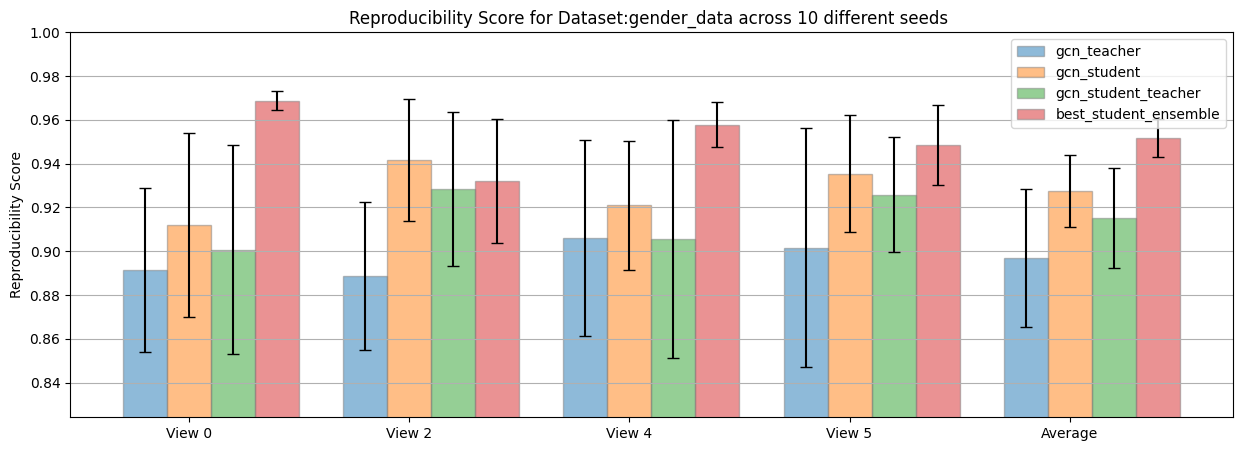

<Figure size 1500x500 with 0 Axes>

In [211]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args,
        gcn_student_ensamble_args,
    ], 
    save_fig=False)

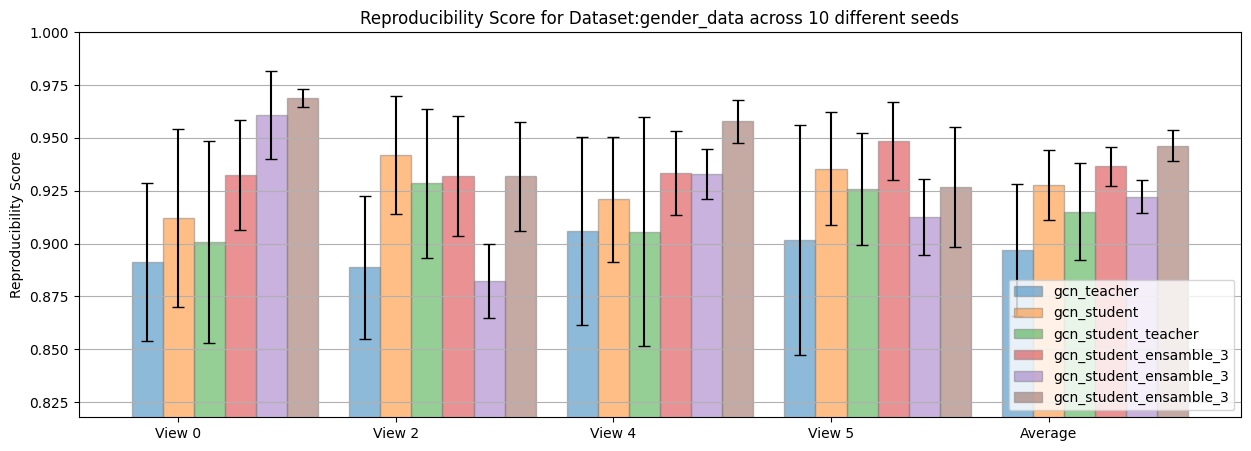

<Figure size 1500x500 with 0 Axes>

In [208]:
plot_bar_chart_reproducibility_mulitple_runs(dataset="gender_data", 
                                             views=[0, 2, 4, 5], 
                                             models=[  "gcn", 
                                                       "gcn_student",
                                                       "gcn_student_teacher",
                                                       "gcn_student_ensamble_3", 
                                                       "gcn_student_ensamble_3", 
                                                       "gcn_student_ensamble_3"
                                                    ], 
                                             students=[-1, -1, -1, 0, 1, 2],
                                             CV=["3Fold", "5Fold", "10Fold"], 
                                             runs=[i for i in range(10)], 
                                             model_args = [
                                                 gcn_args,
                                                 gcn_student_args,
                                                 gcn_student_args,
                                                 gcn_student_ensamble_args,
                                                 gcn_student_ensamble_args,
                                                 gcn_student_ensamble_args
                                             ],
                                             save_fig=False)